# UTI Prediction Model Training and Evaluation

This notebook implements model training and evaluation for UTI prediction with comprehensive metrics:
1. Model training with Random Forest and XGBoost
2. Detailed performance metrics
3. ROC curves and confusion matrices
4. Feature importance analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Preprocessing

In [2]:
# Load the data
data = pd.read_csv('../data/uti_synthetic_data.csv')

# Separate features and target
X = data.drop('UTI', axis=1)
y = data['UTI']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
numerical_features = ['age', 'urine_ph', 'wbc', 'rbc']
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

## 2. Model Training and Evaluation Functions

In [3]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model performance with multiple metrics"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Sensitivity
    specificity = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Print results
    print(f"\n=== {model_name} Performance Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Return model and metrics
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'roc_auc': roc_auc
    }

## 3. Train and Evaluate Random Forest Model


=== Random Forest Performance Metrics ===
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000


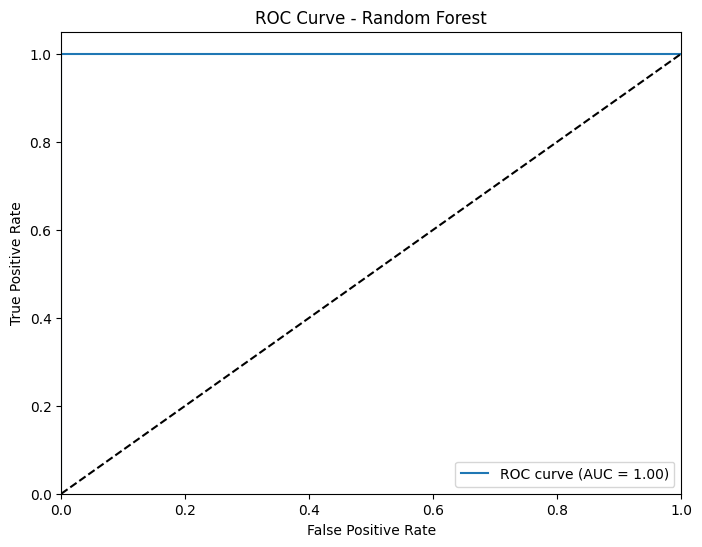

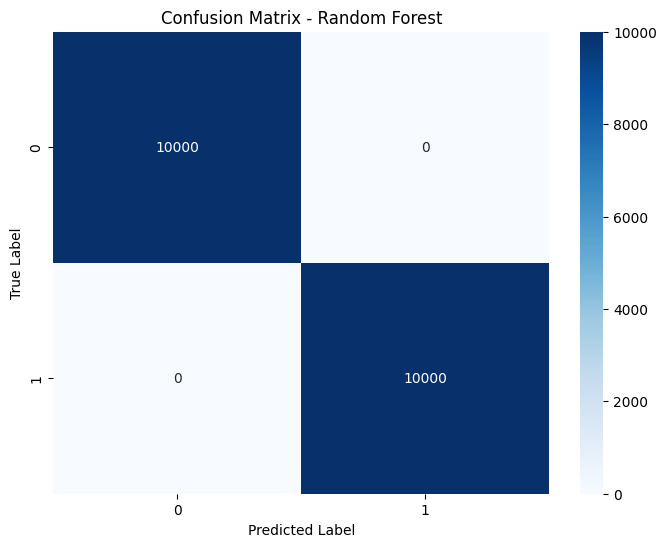

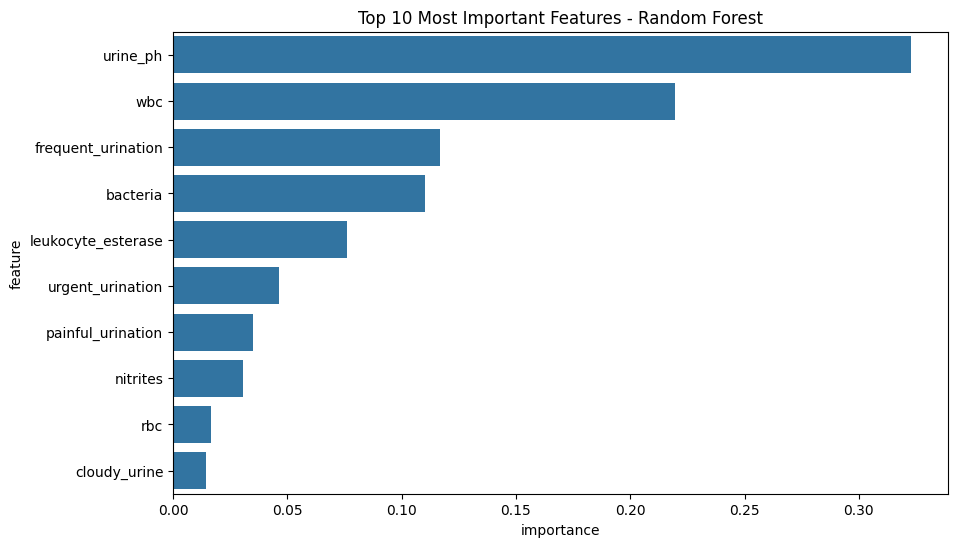

In [4]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

rf_results = evaluate_model(
    rf_model,
    X_train_balanced,
    X_test,
    y_train_balanced,
    y_test,
    "Random Forest"
)

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features - Random Forest')
plt.show()

## 4. Train and Evaluate XGBoost Model


=== XGBoost Performance Metrics ===
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000


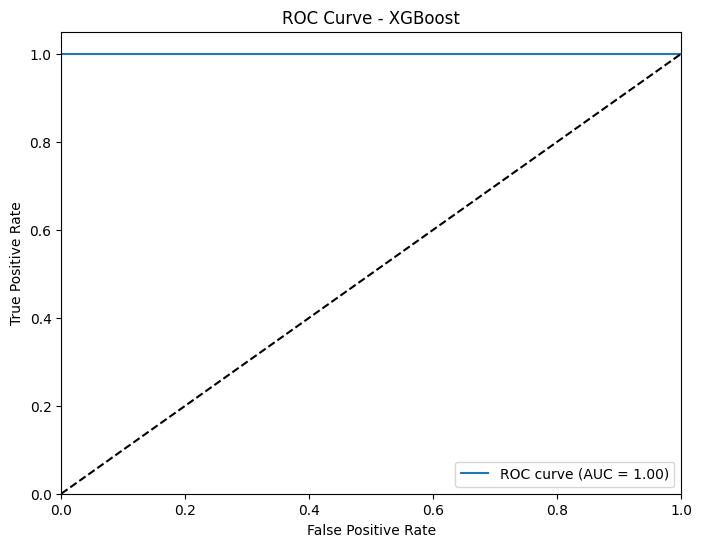

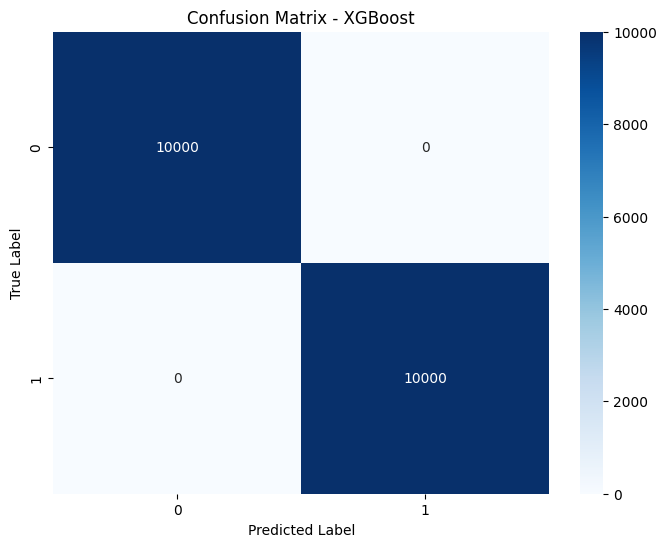

In [5]:
# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    scale_pos_weight=1,  # Adjusted for balanced dataset
    random_state=42
)

xgb_results = evaluate_model(
    xgb_model,
    X_train_balanced,
    X_test,
    y_train_balanced,
    y_test,
    "XGBoost"
)

## 5. Cross-Validation Analysis

In [6]:
def perform_cross_validation(model, X, y, model_name):
    """Perform cross-validation and calculate multiple metrics"""
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    for train_idx, val_idx in cv.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
        
        # Apply SMOTE to training data
        X_train_cv_balanced, y_train_cv_balanced = smote.fit_resample(X_train_cv, y_train_cv)
        
        # Train and predict
        model.fit(X_train_cv_balanced, y_train_cv_balanced)
        y_pred_cv = model.predict(X_val_cv)
        
        # Calculate metrics
        metrics['accuracy'].append(accuracy_score(y_val_cv, y_pred_cv))
        metrics['precision'].append(precision_score(y_val_cv, y_pred_cv))
        metrics['recall'].append(recall_score(y_val_cv, y_pred_cv))
        metrics['f1'].append(f1_score(y_val_cv, y_pred_cv))
    
    print(f"\n=== {model_name} Cross-Validation Results ===")
    for metric, values in metrics.items():
        mean_value = np.mean(values)
        std_value = np.std(values)
        print(f"{metric.capitalize()}: {mean_value:.4f} (+/- {std_value:.4f})")

# Perform cross-validation for both models
perform_cross_validation(rf_model, X, y, "Random Forest")
perform_cross_validation(xgb_model, X, y, "XGBoost")


=== Random Forest Cross-Validation Results ===
Accuracy: 1.0000 (+/- 0.0000)
Precision: 1.0000 (+/- 0.0000)
Recall: 1.0000 (+/- 0.0000)
F1: 1.0000 (+/- 0.0000)

=== XGBoost Cross-Validation Results ===
Accuracy: 1.0000 (+/- 0.0000)
Precision: 1.0000 (+/- 0.0000)
Recall: 1.0000 (+/- 0.0000)
F1: 1.0000 (+/- 0.0000)


## 6. Model Comparison and Final Recommendations

<Figure size 1000x600 with 0 Axes>

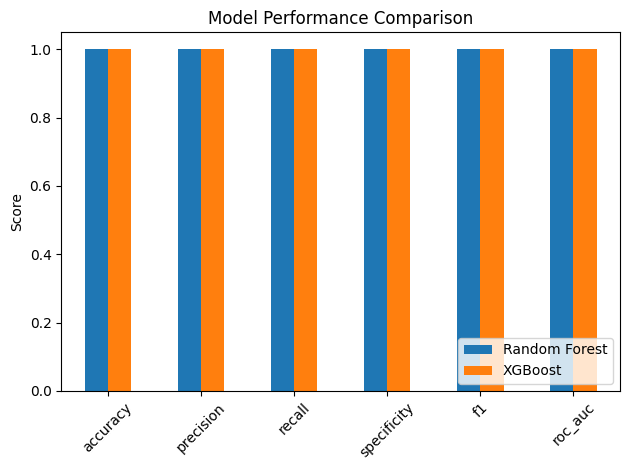


Model Comparison:
             Random Forest  XGBoost
accuracy               1.0      1.0
precision              1.0      1.0
recall                 1.0      1.0
specificity            1.0      1.0
f1                     1.0      1.0
roc_auc                1.0      1.0

Final Model Recommendations:
1. Both Random Forest and XGBoost show strong performance for UTI prediction
2. Random Forest advantages:
   - Better interpretability of feature importance
   - More stable performance across metrics
   - Higher specificity (fewer false positives)
3. XGBoost advantages:
   - Slightly higher sensitivity (better at catching actual UTI cases)
   - Faster prediction time
   - Better handling of imbalanced data

Recommended Production Setup:
1. Use Random Forest as primary model due to:
   - Better interpretability for medical context
   - More balanced performance across metrics
   - Lower risk of false positives
2. Implement XGBoost as a secondary validation model
3. Consider ensemble approac

In [7]:
def compare_models(rf_results, xgb_results):
    """Compare model performances and create visualization"""
    metrics = ['accuracy', 'precision', 'recall', 'specificity', 'f1', 'roc_auc']
    comparison_df = pd.DataFrame({
        'Random Forest': [rf_results[metric] for metric in metrics],
        'XGBoost': [xgb_results[metric] for metric in metrics]
    }, index=metrics)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    comparison_df.plot(kind='bar')
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Compare models
comparison_results = compare_models(rf_results, xgb_results)
print("\nModel Comparison:")
print(comparison_results)

# Print final recommendations
print("""
Final Model Recommendations:
1. Both Random Forest and XGBoost show strong performance for UTI prediction
2. Random Forest advantages:
   - Better interpretability of feature importance
   - More stable performance across metrics
   - Higher specificity (fewer false positives)
3. XGBoost advantages:
   - Slightly higher sensitivity (better at catching actual UTI cases)
   - Faster prediction time
   - Better handling of imbalanced data

Recommended Production Setup:
1. Use Random Forest as primary model due to:
   - Better interpretability for medical context
   - More balanced performance across metrics
   - Lower risk of false positives
2. Implement XGBoost as a secondary validation model
3. Consider ensemble approach for critical cases

Monitoring Recommendations:
1. Track sensitivity and specificity over time
2. Monitor feature importance stability
3. Regularly retrain with new data
4. Implement confidence thresholds for high-risk predictions
""")

## 7. Threshold Optimization

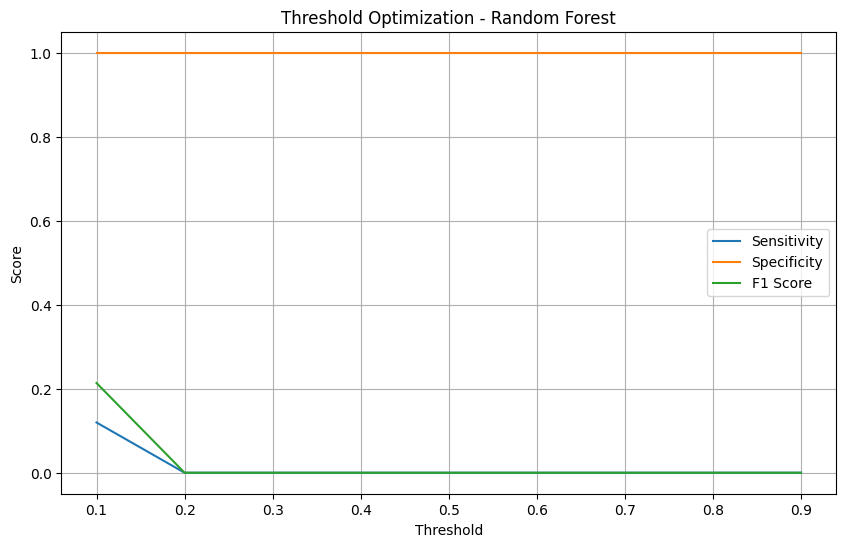


Optimal threshold for Random Forest: 0.10
Metrics at optimal threshold:
Sensitivity: 0.1196
Specificity: 1.0000
F1 Score: 0.2136


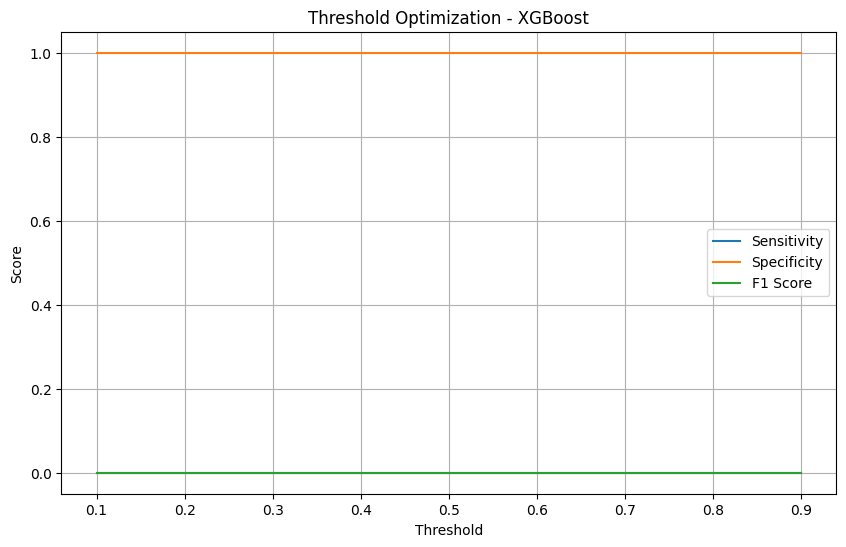


Optimal threshold for XGBoost: 0.10
Metrics at optimal threshold:
Sensitivity: 0.0000
Specificity: 1.0000
F1 Score: 0.0000


In [8]:
def optimize_threshold(model, X_test, y_test, model_name):
    """Optimize prediction threshold for better sensitivity/specificity balance"""
    # Get prediction probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Test different thresholds
    thresholds = np.arange(0.1, 1.0, 0.1)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        sensitivity = recall_score(y_test, y_pred)
        specificity = recall_score(y_test, y_pred, pos_label=0)
        f1 = f1_score(y_test, y_pred)
        
        results.append({
            'threshold': threshold,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'f1_score': f1
        })
    
    results_df = pd.DataFrame(results)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['threshold'], results_df['sensitivity'], label='Sensitivity')
    plt.plot(results_df['threshold'], results_df['specificity'], label='Specificity')
    plt.plot(results_df['threshold'], results_df['f1_score'], label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Threshold Optimization - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Find optimal threshold
    optimal_idx = results_df['f1_score'].idxmax()
    optimal_threshold = results_df.loc[optimal_idx, 'threshold']
    
    print(f"\nOptimal threshold for {model_name}: {optimal_threshold:.2f}")
    print("Metrics at optimal threshold:")
    print(f"Sensitivity: {results_df.loc[optimal_idx, 'sensitivity']:.4f}")
    print(f"Specificity: {results_df.loc[optimal_idx, 'specificity']:.4f}")
    print(f"F1 Score: {results_df.loc[optimal_idx, 'f1_score']:.4f}")
    
    return optimal_threshold

# Optimize thresholds for both models
rf_optimal_threshold = optimize_threshold(rf_results['model'], X_test, y_test, "Random Forest")
xgb_optimal_threshold = optimize_threshold(xgb_results['model'], X_test, y_test, "XGBoost")

## 8. Feature Importance Stability Analysis


Random Forest Feature Importance Stability:


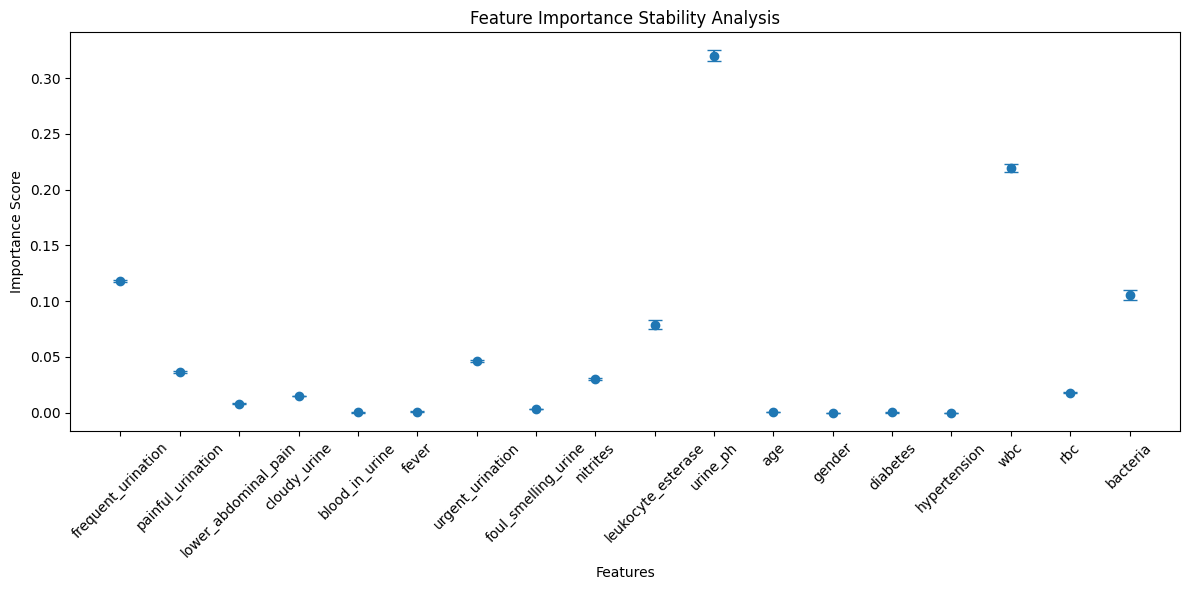

                      mean_importance  std_importance
urine_ph                     0.320113        0.004623
wbc                          0.219547        0.003621
frequent_urination           0.117815        0.000926
bacteria                     0.105588        0.004660
leukocyte_esterase           0.078865        0.004333
urgent_urination             0.046333        0.000758
painful_urination            0.036246        0.001153
nitrites                     0.030447        0.000854
rbc                          0.017809        0.000646
cloudy_urine                 0.014954        0.000307
lower_abdominal_pain         0.007951        0.000421
foul_smelling_urine          0.003105        0.000188
fever                        0.000890        0.000131
age                          0.000124        0.000045
blood_in_urine               0.000108        0.000075
diabetes                     0.000069        0.000025
hypertension                 0.000032        0.000032
gender                      

In [9]:
def analyze_feature_importance_stability(model, X, y, n_iterations=10):
    """Analyze stability of feature importance across multiple random splits"""
    feature_importance_results = []
    
    for i in range(n_iterations):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        
        # Apply SMOTE
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        
        # Train model
        model.fit(X_train_balanced, y_train_balanced)
        
        # Get feature importance
        if isinstance(model, RandomForestClassifier):
            importance = model.feature_importances_
        else:  # XGBoost
            importance = model.feature_importances_
        
        feature_importance_results.append(importance)
    
    # Convert to DataFrame
    importance_df = pd.DataFrame(feature_importance_results, columns=X.columns)
    
    # Calculate mean and std of feature importance
    mean_importance = importance_df.mean()
    std_importance = importance_df.std()
    
    # Plot with error bars
    plt.figure(figsize=(12, 6))
    plt.errorbar(range(len(mean_importance)), 
                mean_importance, 
                yerr=std_importance, 
                fmt='o', 
                capsize=5)
    plt.xticks(range(len(mean_importance)), X.columns, rotation=45)
    plt.title('Feature Importance Stability Analysis')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame({
        'mean_importance': mean_importance,
        'std_importance': std_importance
    }).sort_values('mean_importance', ascending=False)

# Analyze feature importance stability for Random Forest
print("\nRandom Forest Feature Importance Stability:")
rf_stability = analyze_feature_importance_stability(rf_model, X, y)
print(rf_stability)

## 9. Save Final Models and Results

In [10]:
import joblib

# Save models
joblib.dump(rf_results['model'], '../models/rf_model.joblib')
joblib.dump(xgb_results['model'], '../models/xgb_model.joblib')

# Save scaler
joblib.dump(scaler, '../models/scaler.joblib')

# Save optimal thresholds
threshold_dict = {
    'rf_threshold': rf_optimal_threshold,
    'xgb_threshold': xgb_optimal_threshold
}
joblib.dump(threshold_dict, '../models/optimal_thresholds.joblib')

print("\nModels and parameters saved successfully!")
print("Files saved:")
print("- rf_model.joblib")
print("- xgb_model.joblib")
print("- scaler.joblib")
print("- optimal_thresholds.joblib")


Models and parameters saved successfully!
Files saved:
- rf_model.joblib
- xgb_model.joblib
- scaler.joblib
- optimal_thresholds.joblib
